In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
# Path for csv files
files_path ='../../../raw_data/model_trial/'

# List of files csv
df = pd.read_csv(files_path + 'london_merged.csv',parse_dates=['timestamp'], index_col='timestamp')

In [3]:
df = df[['cnt']]

In [4]:
df.head()

cnt
timestamp               
2015-01-04 00:00:00  182
2015-01-04 01:00:00  138
2015-01-04 02:00:00  134
2015-01-04 03:00:00   72
2015-01-04 04:00:00   47

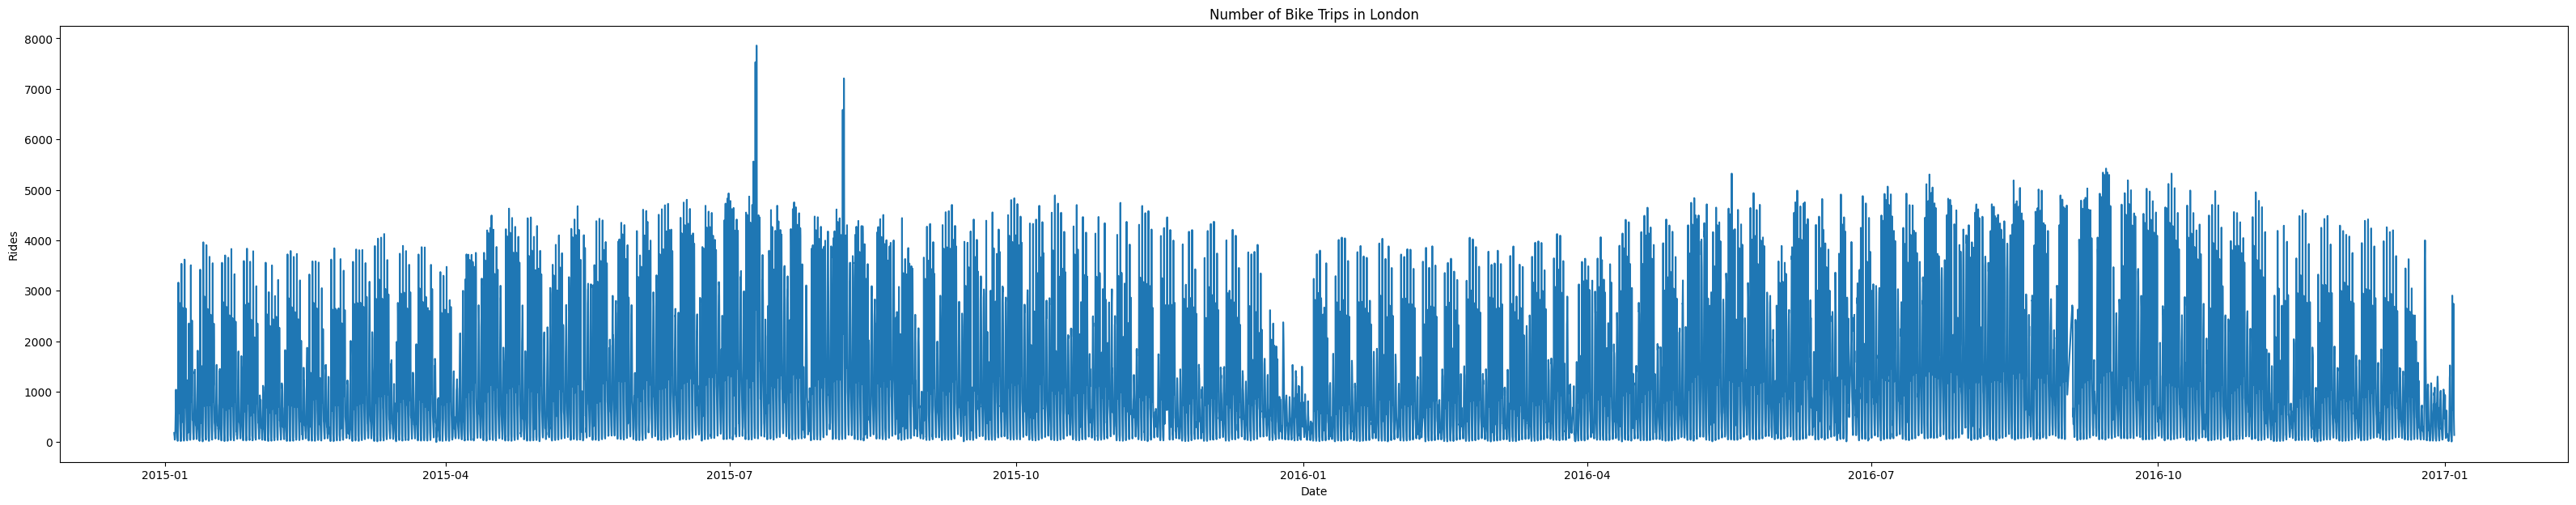

In [5]:
plt.figure(figsize=(40,7))
plt.title("Number of Bike Trips in London")
plt.xlabel('Date')
plt.ylabel('Rides')
plt.plot(df)
plt.show()

In [6]:
steps=-1
dataset_for_prediction= df.copy()

In [7]:
dataset_for_prediction['actual']=dataset_for_prediction['cnt'].shift(steps)

In [8]:
dataset_for_prediction.head(3)

cnt  actual
timestamp                       
2015-01-04 00:00:00  182   138.0
2015-01-04 01:00:00  138   134.0
2015-01-04 02:00:00  134    72.0

In [9]:
dataset_for_prediction=dataset_for_prediction.dropna()

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))

In [11]:
scaled_input = sc_in.fit_transform(dataset_for_prediction[['cnt']])

In [12]:
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [13]:
X.rename(columns={0:'cnt'}, inplace= True)

In [14]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [15]:
y.rename(columns={0:'nextday'}, inplace= True)
y.index=dataset_for_prediction.index
y.head(2)

nextday
timestamp                    
2015-01-04 00:00:00  0.017557
2015-01-04 01:00:00  0.017048

In [16]:
train_size=int(len(df) *0.7)
test_size = int(len(df)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [17]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [18]:
y_test=y['nextday'][:train_size].dropna()
test_adf(y_test, "Prediction")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Prediction


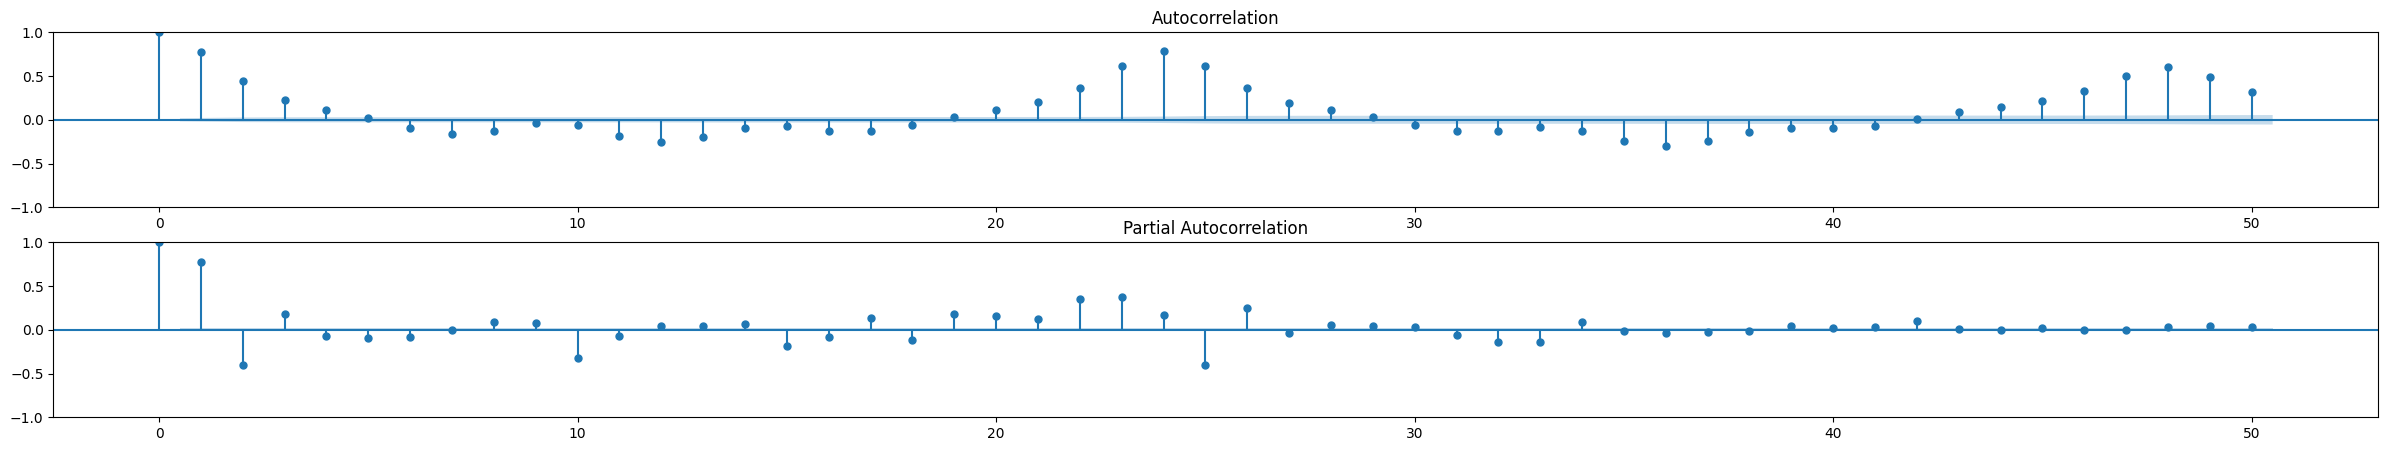

In [19]:
fig,ax= plt.subplots(2,1, figsize=(30,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [20]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-26054.718, Time=5.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24435.088, Time=1.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25220.888, Time=0.99 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-25947.638, Time=3.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24437.087, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-28194.266, Time=23.98 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26813.428, Time=3.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-28505.787, Time=25.41 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-26866.330, Time=6.71 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-28214.802, Time=32.70 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-28313.909, Time=28.90 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-28505.327, Time=26.99 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-26885.395, Time=5.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=39.95 sec
 ARIMA

In [21]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                12189
Model:               SARIMAX(3, 1, 1)   Log Likelihood               14258.894
Date:                Mon, 04 Sep 2023   AIC                         -28505.787
Time:                        14:39:52   BIC                         -28461.338
Sample:                             0   HQIC                        -28490.888
                              - 12189                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.294e-06   1.52e-05      0.413      0.679   -2.36e-05    3.61e-05
ar.L1          1.1723      0.009    135.812      0.000       1.155       1.189
ar.L2         -0.6275      0.016    -38.494      0.000      -0.659      -0.596
ar.L3          0.1738      0.016     11.163      0.000       0.143       0.204
ma.L1         -0.9881      0.003   -319.191      0.000      -0.994      -0.982
sigma2         0.0057   6.03e-05     94.164      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                   1.24   Jarque-Bera (JB):              8594.37
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.48
Prob(H) (two-sided):                  0.06   Kurtosis:                         7.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
train_y.shape , train_X.shape

((12189, 1), (12189, 1))

In [23]:
train_X['index'] =train_y.index

In [24]:
train_X = train_X.set_index('index')

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
 exog=train_X,
 order=(3,1,1),
 enforce_invertibility=False, enforce_stationarity=False)

/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [26]:
results= model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09972D+00    |proj g|=  1.75465D-02


 This problem is unconstrained.



At iterate    5    f= -1.10032D+00    |proj g|=  3.35910D-02

At iterate   10    f= -1.10212D+00    |proj g|=  1.56045D-02

At iterate   15    f= -1.10215D+00    |proj g|=  7.28330D-04

At iterate   20    f= -1.15055D+00    |proj g|=  1.39038D+00

At iterate   25    f= -1.16524D+00    |proj g|=  1.00377D-01

At iterate   30    f= -1.17206D+00    |proj g|=  5.90294D-01

At iterate   35    f= -1.17430D+00    |proj g|=  1.37772D-01

At iterate   40    f= -1.17479D+00    |proj g|=  4.71169D-02

At iterate   45    f= -1.17480D+00    |proj g|=  5.66195D-03

At iterate   50    f= -1.17480D+00    |proj g|=  4.24042D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [67]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)

/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [68]:
forecast_1= results.forecast(steps=test_size-1, exog=test_X)

/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [69]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [76]:
act

nextday
timestamp                    
2016-05-28 18:00:00  0.286387
2016-05-28 19:00:00  0.180280
2016-05-28 20:00:00  0.116412
2016-05-28 21:00:00  0.096056
2016-05-28 22:00:00  0.100382
...                       ...
2017-01-03 18:00:00  0.132570
2017-01-03 19:00:00  0.068830
2017-01-03 20:00:00  0.042875
2017-01-03 21:00:00  0.028499
2017-01-03 22:00:00  0.017684

[5224 rows x 1 columns]

In [70]:
predictions=pd.DataFrame(predictions)

In [75]:
predictions

predicted_mean
timestamp                          
2016-05-28 18:00:00        0.283402
2016-05-28 19:00:00        0.232754
2016-05-28 20:00:00        0.178252
2016-05-28 21:00:00        0.148760
2016-05-28 22:00:00        0.138856
...                             ...
2017-01-03 18:00:00        0.221931
2017-01-03 19:00:00        0.153920
2017-01-03 20:00:00        0.124996
2017-01-03 21:00:00        0.113218
2017-01-03 22:00:00        0.106694

[5224 rows x 1 columns]

In [74]:
predictions['timestamp'] = act.index
predictions = predictions.set_index('timestamp')

<Axes: xlabel='timestamp'>

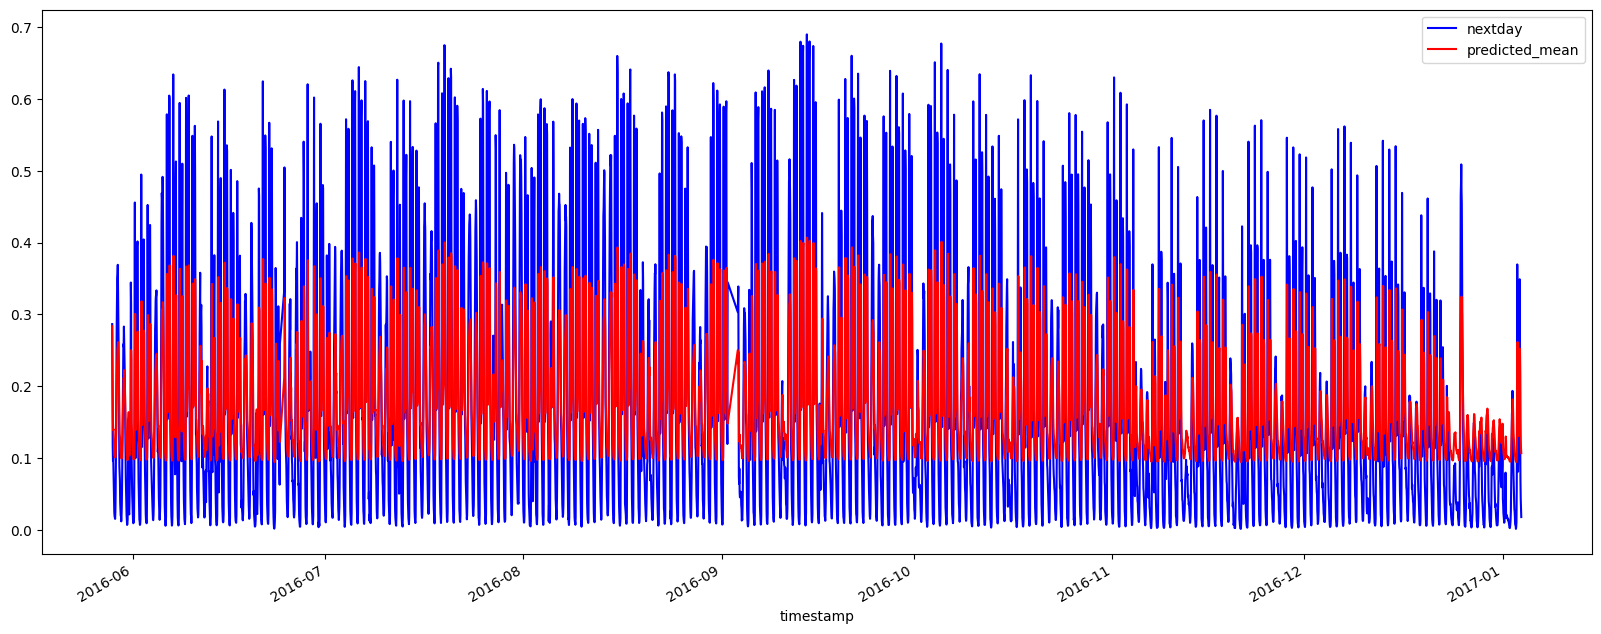

In [80]:
act['nextday'].plot(figsize=(30,8), legend=True, color='blue')
predictions['predicted_mean'].plot(legend=True, color='red', figsize=(20,8))

In [92]:
act_f = pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [94]:
act_f

nextday
timestamp                    
2016-05-28 18:00:00  0.286387
2016-05-28 19:00:00  0.180280
2016-05-28 20:00:00  0.116412
2016-05-28 21:00:00  0.096056
2016-05-28 22:00:00  0.100382
...                       ...
2017-01-03 18:00:00  0.132570
2017-01-03 19:00:00  0.068830
2017-01-03 20:00:00  0.042875
2017-01-03 21:00:00  0.028499
2017-01-03 22:00:00  0.017684

[5224 rows x 1 columns]

In [ ]:
forecast_apple= pd.DataFrame(forecast_1)
forecast_apple.rename(columns={0:'Forecast'}, inplace=True)
forecast_apple.index=predictions.index

In [93]:
forecast_apple

predicted_mean
timestamp                          
2016-05-28 18:00:00        0.283402
2016-05-28 19:00:00        0.232754
2016-05-28 20:00:00        0.178252
2016-05-28 21:00:00        0.148760
2016-05-28 22:00:00        0.138856
...                             ...
2017-01-03 18:00:00        0.221931
2017-01-03 19:00:00        0.153920
2017-01-03 20:00:00        0.124996
2017-01-03 21:00:00        0.113218
2017-01-03 22:00:00        0.106694

[5224 rows x 1 columns]

<Axes: xlabel='timestamp'>

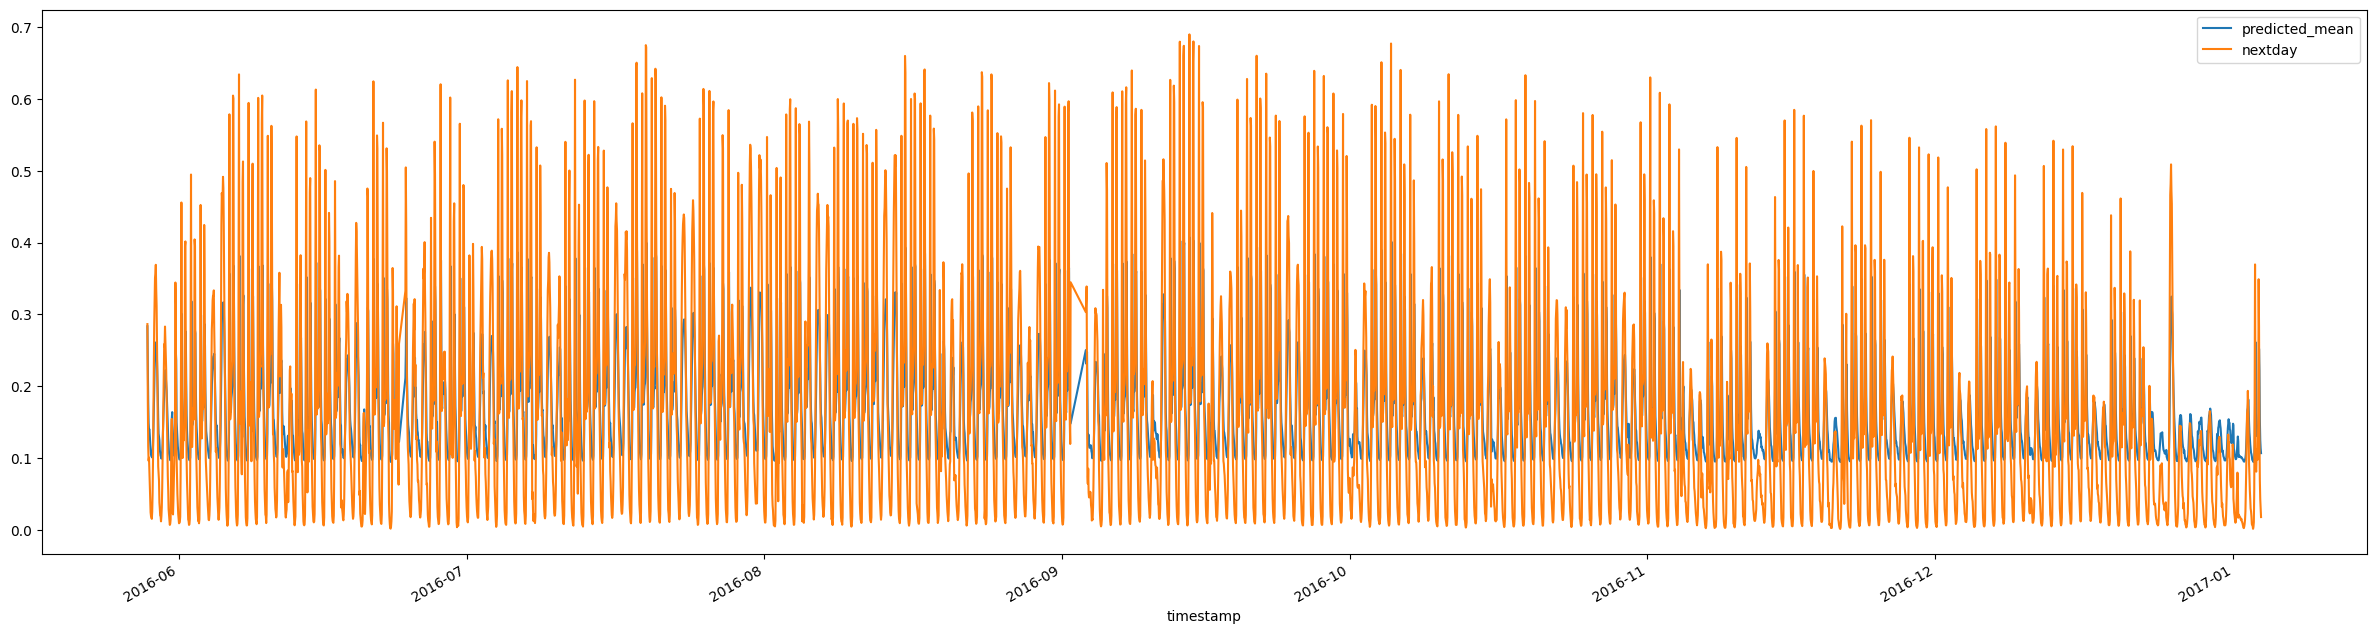

In [96]:
forecast_apple['predicted_mean'].plot(legend=True,figsize=(30,8))
act_f['nextday'].plot(legend=True)

In [98]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['predicted_mean'], act['nextday'])
error

0.10417024779044946

In [99]:
trainPredict = sc_out.inverse_transform(predictions[['predicted_mean']])
testPredict = sc_out.inverse_transform(act[['nextday']])

In [106]:
trainPredict = pd.DataFrame(trainPredict)
trainPredict.index = predictions.index 

testPredict = pd.DataFrame(testPredict)
testPredict.index = predictions.index 

<Axes: xlabel='timestamp'>

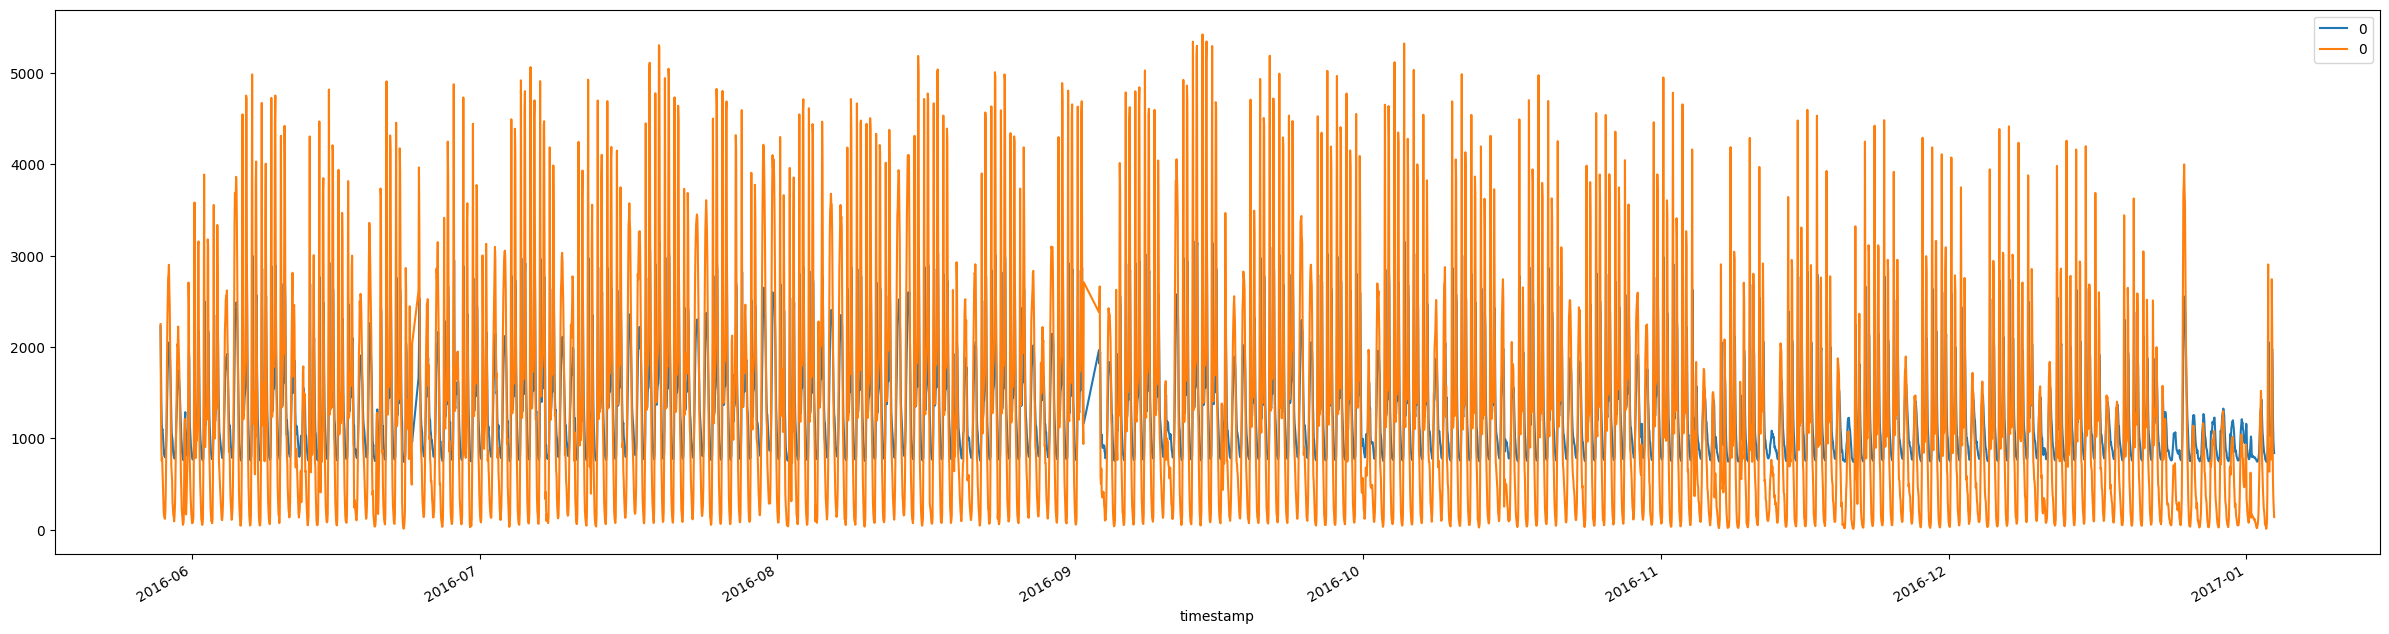

In [112]:
trainPredict[0].plot(legend=True,figsize=(30,8))
testPredict[0].plot(legend=True,figsize=(30,8))